## Content

- [Task 1 and 2](#Task-1-and-2)
- [Task 3](#Task-3)
- [Task 4](#Task-4)
- [Task 5](#Task-5)
- [Task 6](#Task-6)
- [Summary](#Summary)

In [1]:
import json

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

from utils.data_utils import connect_to_db, create_sample, add_features

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Connect to Database

In [10]:
engine, inspector, tables_in_db = connect_to_db()
print(f"Available tables: {tables_in_db}")

Available tables: ['customers', 'transactions']


### Load extension for SQL queries

In [11]:
%load_ext sql

In [12]:
%sql sqlite:///data/viabill.db

### Task 1 and 2

**1.Select transactions that you use as credit applications (write SQL query):**
    
a. select the last transaction (transactionID increases with time) for each customer in Transaction table <br>
b. join result from previous point with customer Income - if Income is Missing replace it with -999 value

**2.Create a new feature based on transaction data - using Python or/and SQL:**

a. create “trans_price_avg_lst3” – for credit applications (transactions selected in point 1)
calculate a value that present an average price of 3 previous transactions

In [13]:
%%sql
WITH last_transaction as (
        SELECT customerID, max(transactionID) as last_transactionID
        FROM transactions
        GROUP BY customerID
),

last_three_transactions as (
        SELECT t.*, avg(price) OVER (PARTITION BY t.customerID ORDER BY transactionID ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) as trans_price_avg_lst3
        FROM transactions t
)

SELECT  t.*, 
        CASE WHEN cust.income is null then -999 else cust.income end as income
        
FROM last_three_transactions t
INNER JOIN last_transaction lt
    ON t.customerID = lt.customerID AND t.transactionID = lt.last_transactionID
INNER JOIN customers cust
    ON t.customerID = cust.customerID
ORDER BY t.customerID
LIMIT 10

 * sqlite:///data/viabill.db
Done.


transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,trans_price_avg_lst3,income
1697842,248,1,147,0,0,0,0,119.33333333333333,-999
1834257,392,2,150,0,0,0,0,98.33333333333333,43200
1974624,396,3,140,0,0,0,0,114.33333333333333,70200
1536291,544,4,136,0,1,0,0,None,93900
661121,984,5,181,0,0,0,0,64.33333333333333,77000
1964705,533,6,33,0,0,0,0,190.0,77500
313094,759,7,195,0,0,0,0,None,13600
1848871,123,9,31,0,0,0,0,105.5,2700
1854937,461,10,5,0,0,0,2,90.33333333333333,80000
696173,447,11,42,0,0,0,0,133.5,57000


*NOTE:* Both tasks were done in one query. Notice, that `trans_price_avg_lst3` may contain None values, which means that for this customerIDs the last transaction is actually the  first one. That's why we can not calculate average value of three previous transactions, as there are no such. Additional suggestion may be to round values to 2 decimals.

### Task 3

Check if there is a dependency between age and sex in the data – use statistical test if applicable.

To check the dependancy between two variables we may check correlation between them and in our case plot a distribution of `Age` depending on `Sex`. For simplicity I'll read `customers` table with Pandas.

In [14]:
customers = pd.read_sql_table("customers", con=engine)
print(customers.shape)
customers.head(3)

(500000, 6)


,customerID,sex,age,residentialAddress,postalAddress,income
0,1,1,25,28 Irvine Place,28 Irvine Place,NaN
1,2,1,19,72 Bertha Street,72 Bertha Street,43200.0
2,3,2,22,63 Ladberry Street,63 Ladberry Street,70200.0


In [15]:
# fast data types check
customers.dtypes

customerID              int64
sex                     int64
age                     int64
residentialAddress     object
postalAddress          object
income                float64
dtype: object

In [16]:
# fast missing check
customers.isnull().sum()

customerID               0
sex                      0
age                      0
residentialAddress       0
postalAddress            0
income                9975
dtype: int64

In [17]:
# basic stats
customers[["age", "sex"]].describe()

,age,sex
count,500000.000000,500000.000000
mean,44.630508,1.150402
std,16.178283,0.477797
min,5.000000,0.000000
25%,27.000000,1.000000
50%,50.000000,1.000000
75%,58.000000,1.000000
max,90.000000,2.000000


In [18]:
# Correlation seems to be not high.
customers[["age", "sex"]].corr(method="spearman")

,age,sex
age,1.000000,0.001564
sex,0.001564,1.000000


As we may see the distribution of `Age` for different `Sex` levels is almost the same. So, **seems like there is no dependancy between age and sex in the data.** But, worth noticing, there is some strange gap sowhere in between 20 and 60 years old. For some reason people of average age tend to not use ViaBill services.

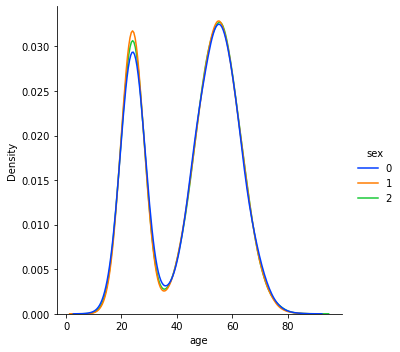

In [19]:
sns.displot(customers, x="age", hue="sex", kind="kde", common_norm=False, palette=sns.color_palette("bright", 3));

### Task 4

The task seems to be not very precise. What does it mean adequate marketing communication? What is a content of this offer? What is assumed target group of this capmpaign? Is it for young people or maybe for elder ones? Maybe we want to attract more clients to our partnering stores in beauty industry, so maybe we should target women? Seems like we need to make some assumptions. I propose some general brainstorming points, which may emphasize some important factors which may be considered during segmentation, depending on our business goal.<br>

* First, we should probably be careful with clients who had any delinquencies using our services. I would rather put them in a separate basket as a group of clients we at some point want to avoid. It can be a group of only defaulted clients, or stricter rule, like somebody who was late with the installment at some point (or late at least for more than couple of days).
* Second, there are clients who regularly use our service or those who used it once or maybe two times. We may ask ourselves, what do we want to achieve? Do we want to contact our regular clients expecting to have higher positive reaction, because of their loyalty or we want to encourage less active users to come back to our service?
* Third, there are clients who spend more on average than others, ViaBill seems to be interested in more expensive transactions to maximize merchant's fee. So, maybe we want to target those who tend to pay more.
* Four, demographic factors. Maybe for some reason we may want to target some age/sex/location group. It may be anything depending on our goal.

Let's assume, ViaBill decided to arrange a marketing campaign to increase sales for new-comming partnering companies from beauty industry which sale luxury cosmetics. Let's assume from analysis we see, that women tend to spend more for beauty-related products. Moreover, probably women elder than 40 years old on average have higher financial possibilities and spend more (on average) on products incl. cosmetics. So, we may target our campaign for women elder than 40, or maybe we may try out men over 40 years old, who may potentially buy smth for their wives or girlfriends.

**What next?**
Should we send the emails to every client > 40 years old? The short answer is - it depends. First of all, we should consider the cost of such email campaign, if it's very low, than we may consider sending marketing communication to even every client. Why not? Additionally, some clients may find our marketing communication offensive and decide to never use ViaBill services again. So, what if we need to optimize our campaign in terms of costs, avoid sending communication to those who will do what we expect anyway and to limit churn rate because of it. We may use A/B test, which is commonly used in Marketing. Plus to this after a while we may build a model trying to identify clients who will probably positively respond to it. So, the loop is the following:

* Split a sample of clients as randomly as possible, both samples should be as similar as possible. Remember avoiding clients who tend to default.
* Now we have group A and group B. Let B to be a smaller sample, just to test our campaign. Send marketing communication to clients from this sample B.
* After a while, analyze the results. Is the purchase rate with ViaBill significantly higher than in sample A?
* Let's build a model, for example `Uplift model` trying to identify which features help us to segment our clients and who of them tend to positively respond to the campaign.
* Use our model to approximate purchase probability for different clients and send communication to a group with the higher one.

### Task 5

Perform exploratory data analysis (EDA) and present interesting findings related to credit risk.

In [21]:
# reading sample
df = create_sample("utils/sample_query.txt")
print(df.shape)
df.head()

(1979983, 13)


,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income
0,1,114,2869,140,0,0,0,0,2,24,74 Ada Street,74 Ada Street,54900.0
1,2,855,124077,70,0,0,0,0,1,46,23 Brampton Street,23 Brampton Street,60000.0
2,3,752,86184,85,0,0,0,0,1,52,96 Avon Street,35 Spurwood Street,7100.0
3,4,246,248861,43,1,0,0,0,1,29,3 Merinda Street,3 Merinda Street,67600.0
4,5,973,162112,127,0,0,0,0,2,30,64 Distribution Street,64 Distribution Street,92000.0


*NOTE:* There are records in transactions table, where customerID is empty. We'll drop them, because we're not able to identify the customer. That's why number of records in a sample is less than in `transactions` table.

#### Main conclusions after EDA:

- Data seems to be synthetic. `price` and `income` seems to be randomly sampled from uniform distribution. `age` has very strange distribution as well, like people of average age don't use ViaBill's service. Besides, there is no dependancy of `default` from `age`, `income` or `price`, which is rahter not natural.
- If client defaulted in some point in time - there is no way this transaction cures (leaves default)
- There is, surprisingly no much difference in default rate for consequative payments for statuses 0 and 1. So, if client is late with a payment, then he/she tend to be late with another payment more, but goes to default rather with the same tendency as those with paytmentStatus = 0. 
- Default rate is rather not high, we may expect unbalanced target, which is normal for Credit Risk tasks.
- There is a high dependancy between `sex` and tendency to `default`. Women tend to go default more.
- Clients who were in default previously tend to default again with probability over above 16%. Some clients defalted 11 times! Those who were late with an installment for previous loans tend to default more than those without any overdue in history, even though the difference is not huge.
- `customerID` should not be used as a feature, because we want to use a model for new customers, besides, this variable has quite high dimensionality.
- There is no strong dependancy between being just late with instalment and going to default. In other words, if the customer has an overdue, still with high probability he/she will pay the loan and most probably in time.
- Adress related data tells not much, just different streets, it's assumed to be not very useful for us.
- `age`, `price` and `income` have very strange values. There are customers of age 5, customers without income and loans for purchases for 3 USD?

Let's calculate the target. Default will be our target, from what we saw in our cross tables, there is no way client leaves default if client went there, so it's enough just to check the last payment status to determine whether it's defaulted one.

In [22]:
# We can do 
df["default"] = np.where(df.paytmentStatus4 == 2, 1, 0)

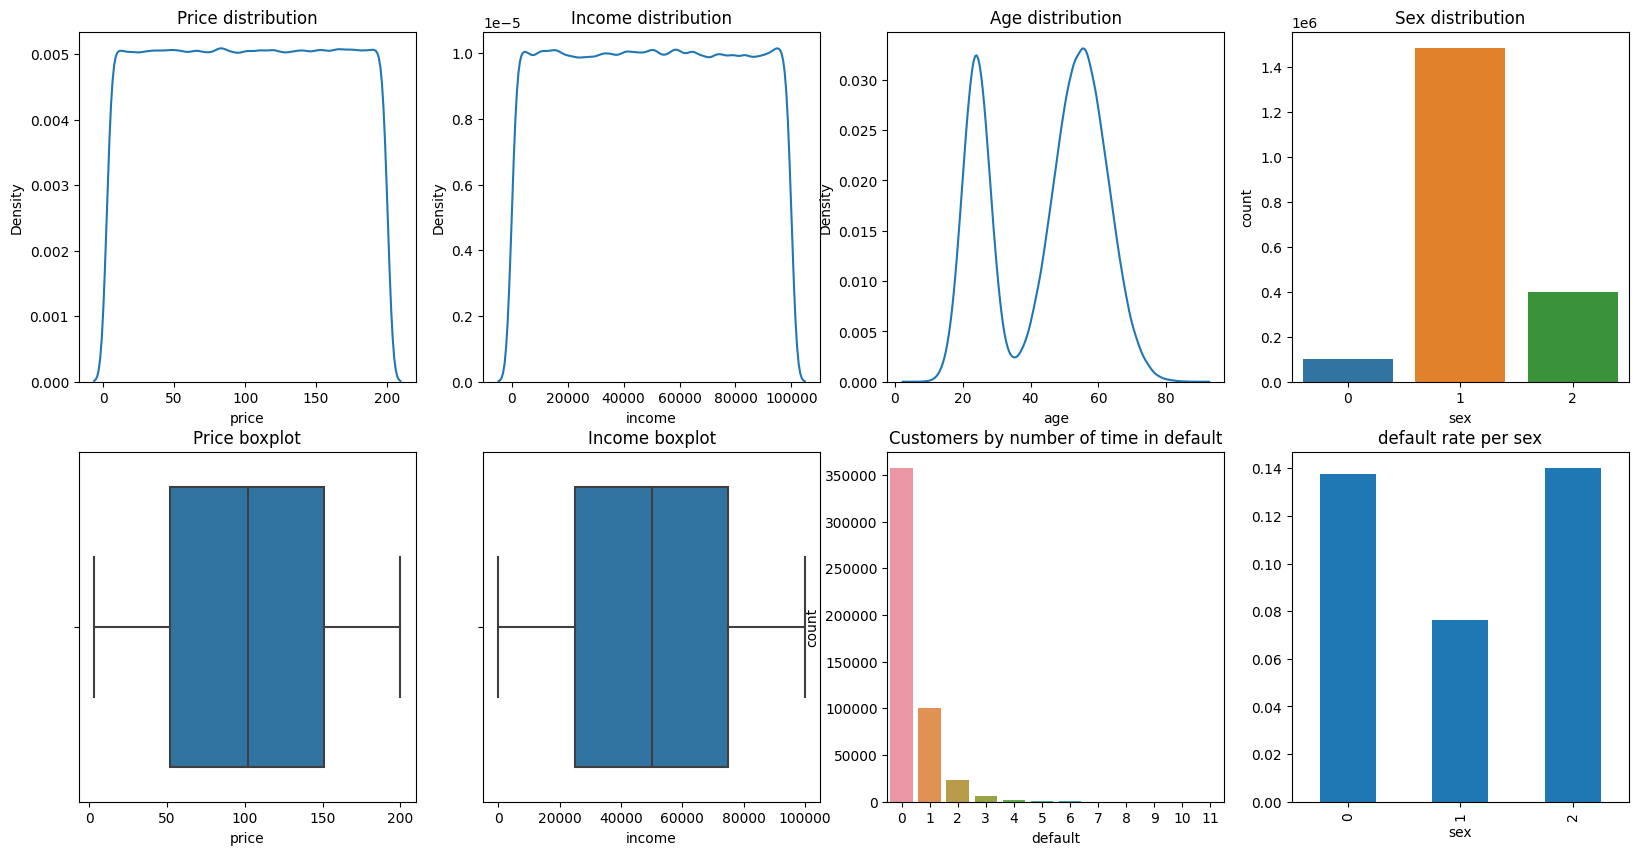

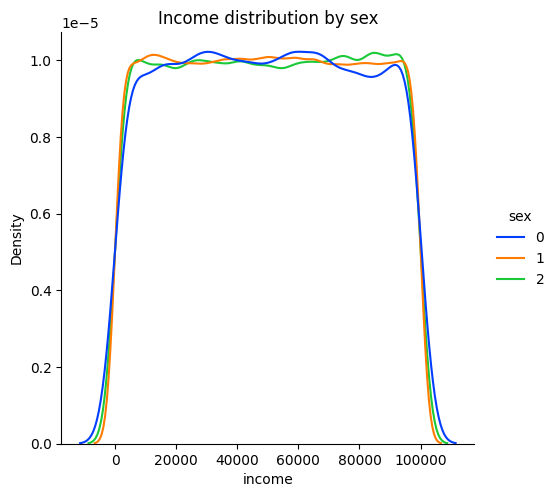

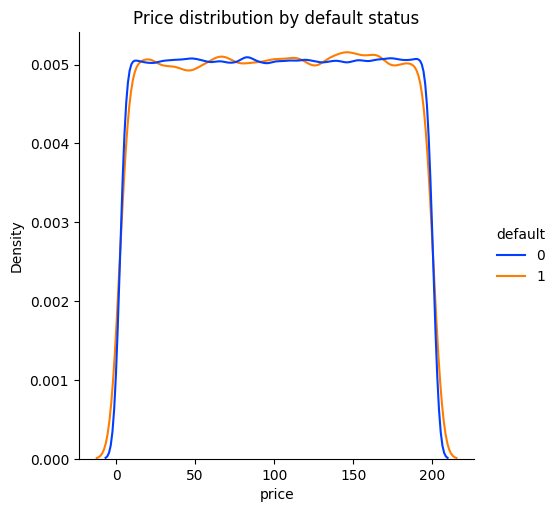

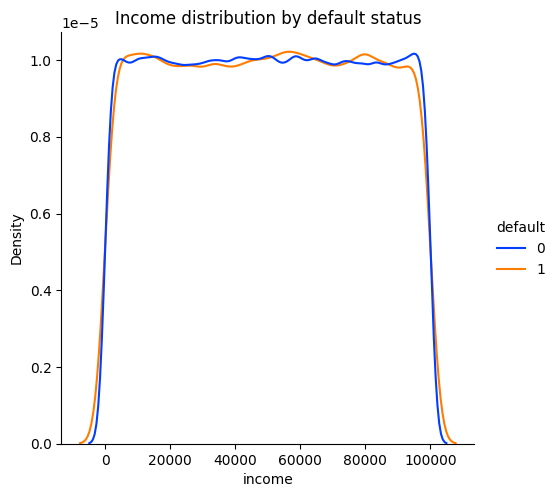

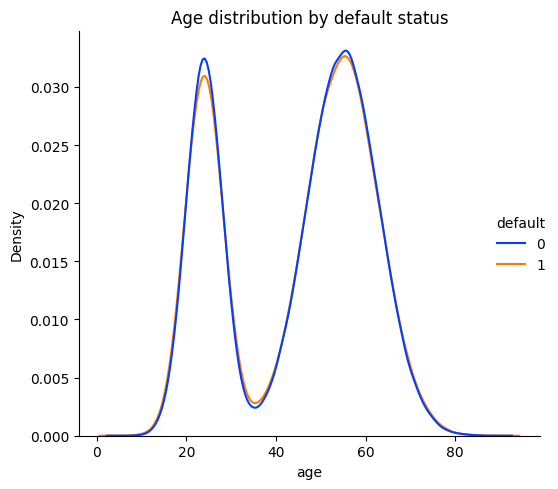

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
sns.kdeplot(x=df.price, ax= axs[0][0]).set(title="Price distribution")
sns.kdeplot(x=df.income, ax= axs[0][1]).set(title="Income distribution")
sns.kdeplot(x=df.age, ax= axs[0][2]).set(title="Age distribution")
sns.countplot(x=df.sex, ax= axs[0][3]).set(title="Sex distribution")
sns.boxplot(x=df.price, ax = axs[1][0]).set(title="Price boxplot")
sns.boxplot(x=df.income, ax = axs[1][1]).set(title="Income boxplot")
sns.countplot(x=df.groupby("customerID").default.sum(), ax = axs[1][2]).set(title="Customers by number of time in default")
df.groupby("sex").default.mean().plot(kind="bar", title="default rate per sex", ax = axs[1][3])
sns.displot(customers, x="income", hue="sex", kind="kde", common_norm=False, palette=sns.color_palette("bright", 3)).set(title="Income distribution by sex")
sns.displot(df, x="price", hue="default", kind="kde", common_norm=False, palette=sns.color_palette("bright", 2)).set(title="Price distribution by default status")
sns.displot(df, x="income", hue="default", kind="kde", common_norm=False, palette=sns.color_palette("bright", 2)).set(title="Income distribution by default status")
sns.displot(df, x="age", hue="default", kind="kde", common_norm=False, palette=sns.color_palette("bright", 2)).set(title="Age distribution by default status")

plt.tight_layout();

In [37]:
# Strange values for income, price and age
df[["income", "price", "age"]].describe()

,income,price,age
count,1940494.000,1979983.000,1979983.000
mean,49990.004,101.521,44.631
std,28909.843,57.178,16.175
min,0.000,3.000,5.000
25%,24900.000,52.000,27.000
50%,50000.000,102.000,50.000
75%,75000.000,151.000,58.000
max,100000.000,200.000,90.000


Payment Statuses and transfers between them

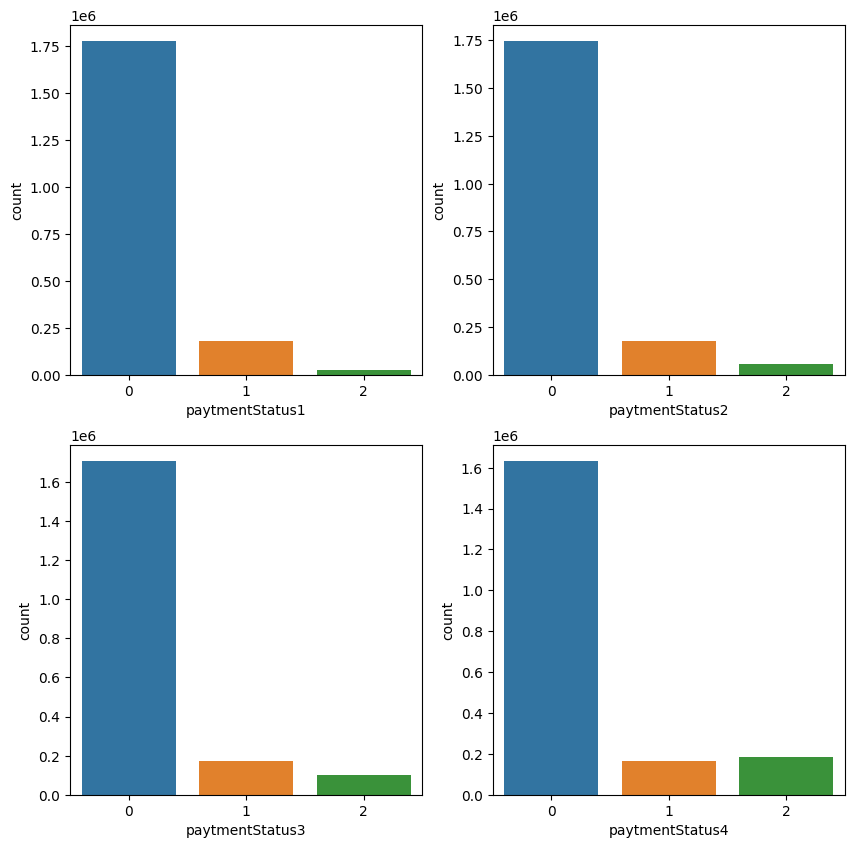

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sns.countplot(x=df.paytmentStatus1, ax=axs[0][0])
sns.countplot(x=df.paytmentStatus2, ax=axs[0][1])
sns.countplot(x=df.paytmentStatus3, ax=axs[1][0])
sns.countplot(x=df.paytmentStatus4, ax=axs[1][1]);

In [40]:
# Loan can not cure. No big difference in default rate between customers paying on time and those who sometimes late.
payments = [(1,2), (2,3), (3,4)]

for idx1, idx2 in payments:
    print(pd.crosstab(index=df[f"paytmentStatus{idx1}"], columns= df[f"paytmentStatus{idx2}"], normalize="index"))
    print("\n")

paytmentStatus2     0     1     2
paytmentStatus1                  
0               0.896 0.088 0.016
1               0.861 0.123 0.016
2               0.000 0.000 1.000


paytmentStatus3     0     1     2
paytmentStatus2                  
0               0.890 0.087 0.023
1               0.855 0.123 0.022
2               0.000 0.000 1.000


paytmentStatus4     0     1     2
paytmentStatus3                  
0               0.871 0.086 0.043
1               0.837 0.121 0.043
2               0.000 0.000 1.000




In [42]:
df = add_features(df)

In [46]:
# If client has defaulted earlier, than client tends to go default again more than those who never defaulted
df.groupby("defaulted_earlier").default.mean()

defaulted_earlier
0   0.079
1   0.167
Name: default, dtype: float64

In [45]:
# Late doesn't mean will not pay at all
df.groupby("late_earlier").default.mean()

late_earlier
0   0.084
1   0.102
Name: default, dtype: float64

### Task 6

Build model/models that predict if customer will not pay back the loan.

After EDA I've made couple assumptions.

- Even so `age`, `income` and `price` seems to be artificially created, let's assume it's ok for the purpose of this toy task and proceed with them. I want to use LogReg as a candidate, so some scaling may be needed. I'll remove records, where `age < 18`, `income < 1000` and `price < 20`. 
- There is an evident dependancy from time, so when splitting sample for train, validation and test it's important to not forget to maintain this dependancy. In other words, train records should be before validation records, validation records should be before test ones.
- There is a difference in default rate between clients who were in default before and never defaulted, so as for those who were late and those who pay in time. So, we'll add 2 new binary features determining whether any previous loans went in default for given client (`defaulted_earlier`) and whether client was late at any moment with his/hers installment (`late_earlier`).
- Address related data, shopID, customerID bring now value for prediction. These variables will be dropped from training sample.
- Target variable is `default` meaning any of payment statuses went to status **2**.
- Let's assume we have no limitations regarding what variables we may use for model, for example `sex` variable may be tricky, as it may cause descrimination which is against some social rules. 

### Running a script
I've developed a script for our experiment. Script does the following:

1. Prepares samples and stores them in data folder together with StandardScaler and OneHotEncoder objects in `pickle` format.

    - connects to database (utils.data_utils.connect_to_db);
    - creates sample joining `transactions` and `customers` tables by customerID removing records with missing customerID (utils.data_utils.create_sample);
    - calculates default per record (utils.data_utils.determine_default);
    - adds `defaulted_earlier` and `late_earlier` features to sample (utils.data_utils.add_features);
    - removes outliers for `age`, `income` and `price` (utils.data_utils.remove_outliers);
    - preprocessing data by OneHot encoding categorical features and Standard scaling numerical features and stores `StandardScaler` and `OneHotEncoder` objects in `pickle` format in data folder (utils.data_utils.preprocess_data);
    - splits sample to train (50% of sample), validation (30% of sample) and test (20% of sample) by `transactionID` dimension (utils.data_utils.split_sample)
    - stores them in data folder (utils.data_utils.prepare_training_samples).
    
    
2. Runs `hyperopt` experiment tuning hyperparameters for two candidant models: `Logistic Regression` and `Random Forest`. We'll track our experiments with `MlFlow`. For more details about hparams search space look at files in directory `training/logistic_regression.py` and `training/random_forest.py`.

In [49]:
!python run_experiments.py

2022/08/07 16:27:20 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/08/07 16:27:20 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Let's look at our best model. It achieves above 60% of ROC AUC on validation sample.

In [64]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
EXPERIMENT_NAME = "viabill-experiment"

client = MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)

best_run = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.roc_auc_score DESC"],
    )[0]

print(f"Best model is {best_run.data.tags['model']}")
print(f"Best params are {best_run.data.params}")
print(f"best ROC AUC score: {round(best_run.data.metrics['roc_auc_score'],5)}")

Best model is Logistic Regression
Best params are {'C': '4.1935243242516655', 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': '42', 'solver': 'liblinear'}
best ROC AUC score: 0.60657


Let's assume we want to deploy our model to production. Then, we need to run `promote_last_best.py` file to register best model in model registry and shift it to production stage. After that we'll move all necessary files to folder `inference/` and will be able to build a docker image and run our Flask web service to be able to predict application default probability. 

In [65]:
!python promote_last_best.py

INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
Successfully registered model 'BestModel'.
2022/08/07 16:39:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: BestModel, version 1
Created version '1' of model 'BestModel'.
INFO:root:ROC AUC score on test sample is 0.610376


Our best model achieves 61% ROC AUC on test set. Not very bad, considering data sems to be almost fully random. :)<br>
Let's build docker image and run our application. For this let's go to `inference/` folder and run command in the terminal:<br>

`docker build -t default-prediction-service:v1 .`

Then, let's run our container.

`docker run -it --rm -p 9696:9696  default-prediction-service:v1`

There is a file in `inference/` folder for app testing - `test.py` and `example_query.json` with example query. Let's look what it contains.

In [2]:
with open("inference/example_application.json", "r", encoding="utf-8") as f:
    application = json.load(f)
application

{'transactionID': 100000,
 'price': 50,
 'income': 10000,
 'age': 35,
 'sex': 1,
 'defaulted_earlier': 0,
 'late_earlier': 0}

Let's send it to our web service.

In [11]:
!python inference/test.py

{'default_prob': 0.43090316807328766, 'transactionID': 100000}


So, the probability of default in this case is 43%.

### Summary

What business value may give such a model? Default prediction model may help us more efficiently manage the risk of our portfolio. By utilizing our model we may reduce the default rate by avoiding approval of some applications with high predicted default risk. Addtionally we may build a scorecard on top of our model.